In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
from scipy.optimize import bisect

# Brachistrochrone

Beim Problem der [Brachistochronen](https://de.wikipedia.org/wiki/Brachistochrone) ist die Frage was das optimale Höhenprofil $y(x)$ ist, auf dem ein Körper reibungsfrei am schnellsten von einem gegebenen Anfangspunkt zu einem gegebenen Endpunkt gleitet.

Wir nehmen im Folgenden an, dass der Anfangspunkt $\vec r_0=(0,0)$ ist und der Endpunkt $\vec r_1=(1,y_1)$ mit $y_1\leq0$. Dann kann die Zeit, die der Körper braucht um von $\vec r_0$ nach $\vec r_1$ zu gelangen, durch

$$
T[y(x)]=\frac{1}{\sqrt{2g}}\int_0^1\sqrt{\frac{1+\Big(\frac{dy}{dx}\Big)^2}{-y(x)}}\ dx
$$

berechnet werden.

Es ist bekannt *\[Joh. Bernoulli, 1696\]*, dass das optimale Höhenprofil beschrieben werden kann als

$$
\begin{aligned}
x(\varphi)&=R\cdot(\varphi -\sin\varphi)\\
y(\varphi)&=R\cdot(\cos\varphi -1)
\end{aligned}
$$

Dabei ist $\varphi\in[0,\varphi_{\text{max}}]$ und die Parameter $R$ und $\varphi_{\text{max}}$ hängen von der Wahl von $y_1$ ab.

Die folgende Funktion berechnet die Brachistochrone für ein gegebenes $y_1$:

In [ ]:
def brachistochrone(y1):
    def fun(phi, y):
        return (np.cos(phi)-1.0)/(phi-np.sin(phi))-y

    phi = bisect(fun, 1e-5, 2*3.1415, args=(y1,))
    R = 1/(phi-np.sin(phi))

    phis=jnp.arange(0,phi,0.01)
    x=jax.vmap(lambda phi: R*(phi-jnp.sin(phi)))(phis)
    y=jax.vmap(lambda phi: R*(jnp.cos(phi)-1.0))(phis)

    return x,y

Wählen wir ein $y_1$ und plotten die zugehörige Brachistochrone:

In [ ]:
y1=-0.3

In [ ]:
xb,yb = brachistochrone(-0.3)
plt.plot(xb,yb)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

# Alternativer Lösungsansatz mit "Maschinellem Lernen"

* Wähle einen Ansatz für eine parametrisierte Funktion $y_\theta(x)$.
* Minimiere $T[y_\theta(x)]$ (die *Kostenfunktion*) durch das Gradientenverfahren.

## Parametrisierter Ansatz: Künstliches Neuronales Netz

Wir definieren ein 3-lagiges neuronales Netz, das für die Eingabe $x$ ein Profil $y(x)$ berechnet:

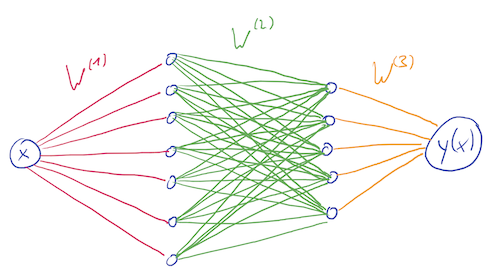

In [ ]:
def neural_net(params, x):
    # Auswerten des neuronalen Netzwerks
    a = jax.nn.softplus( jnp.dot(params["W1"],jnp.array(x)).ravel() + params["b1"] )
    a = jax.nn.softplus( jnp.dot(params["W2"],a) + params["b2"] )
    return jnp.dot(params["W3"],a) + params["b3"]

def get_params(l1, l2):
    # Generiere zufällige Anfangsparameter für das Netzwerk
    key=jax.random.PRNGKey(1234)
    ks = jax.random.split(key,3)
    params = {}
    params["W1"] = jax.random.normal(ks[0], (l1, 1)) / jnp.sqrt(l1)
    params["W2"] = jax.random.normal(ks[1], (l2, l1)) / jnp.sqrt(0.5*(l1+l2))
    params["W3"] = jax.random.normal(ks[2], (1, l2)) / jnp.sqrt(l2)
    params["b1"] = jnp.zeros(l1)
    params["b2"] = jnp.zeros(l2)
    params["b3"] = jnp.zeros(1)
    
    return params

Teste das Profil mit zufälligen Anfangsparametern:

In [ ]:
params = get_params(32,32)

dx=0.01
xgrid=jnp.arange(0,1,dx)
profile=jax.vmap(neural_net, in_axes=(None,0))(params,xgrid)

plt.plot(xgrid,profile)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Das neuronale Netz hält unsere **Randbedingungen**

$$
y(0)=0, y(1)=y_1<0
$$

nicht ein!

Das wird in der folgenden Funktion korrigiert:

In [ ]:
def y_profile_function(params, x, y1):
    f0 = neural_net(params, 0.0)
    f1 = neural_net(params, 1.0)
    return (neural_net(params,x) - f0*(1.0-x) - (f1-y1) * x)[0]

y_profile = partial(y_profile_function, y1=y1)

Wir können die Operationen in `y_profile` in einem **Computational Graph** darstellen:

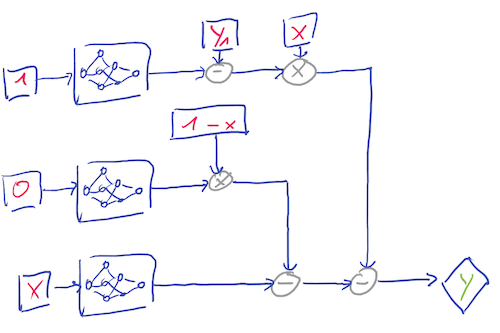

Teste das Profil mit zufälligen Anfangsparametern:

In [ ]:
params = get_params(32,32)

dx=0.01
xgrid=jnp.arange(0,1,dx)
profile=jax.vmap(y_profile, in_axes=(None,0))(params,xgrid)

plt.plot(xgrid,profile)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## Kostenfunktion: Laufzeit der Bahnkurve $y_\theta(x)$

Hier approximieren wir

$$
T[y_\theta(x)]=\int_0^1I_\theta(x)\ dx
\approx\Delta x\sum_{n=0}^{M-1} I_\theta\big((n+\frac12)\Delta x\big)
$$

mit 

$$
I_\theta(x)=\sqrt{\frac{1+\Big(\frac{dy_\theta}{dx}\Big)^2}{-2gy_\theta(x)}}
$$

und $M=\left \lfloor{\frac{1}{\Delta x}}\right \rfloor$.

In [ ]:
def integrand(params,x):
    g = 10
    y = y_profile(params, x)
    dydx  = jax.grad(y_profile, argnums=1)(params,x)
    return jnp.sqrt((1.0 + dydx**2)/(-2.0*g*y))

def cost_T(params):

    dx=0.001
    xgrid=jnp.arange(0.5*dx,1,dx)

    tmp = jax.vmap(lambda x: integrand(params,x))(xgrid)

    return dx * jnp.sum(tmp)

Laufzeit unseres Anfangsprofils:

In [ ]:
cost_T(params)

## Training: Gradientenverfahren

Definiere einen Schritt des Gradientenverfahrens:

$$
\theta^{(k+1)}\leftarrow\theta^{(k)}-\alpha\nabla_\theta T[y_\theta(x)]
$$

Hier ist $0<\alpha$ die **Lernrate**. 

In [ ]:
@jax.jit
def update(params, alpha):
    
    # Gradienten berechnen (autom. Differenzierung)
    gs = jax.grad(cost_T)(params)
    
    # Schritt des Gradientenverfahrens
    g_new = jax.tree_map(lambda x,y: x-alpha*y, params, gs)
    
    return g_new

In [ ]:
# Zufällige Initialisierung
params = get_params(32,32)

# Ausgabe
T = cost_T(params)
step = [0]
cost = [T]
print("Schritt 0 - T =", T)

# Trainingsschleife
for k in range(20000):
    
    # Schritt des Gradientenverfahrens
    params = update(params,0.05)
    
    # Ausgabe
    if ((k+1)%500)==0:
        T = cost_T(params)
        step.append(k+1)
        cost.append(T)
        print("Schritt", k+1, "- T =", T)

In [ ]:
plt.plot(np.array(step), np.array(cost))
plt.ylabel(r"$T[y_{\theta^{(n)}}(x)]$")
plt.xlabel(r"Optimierungsschritt $n$");

## Ergebnis

Visualisiere unser optimiertes Profil im Vergleich zur exakten Brachistochrone:

In [ ]:
dx=0.01
xgrid=jnp.arange(0,1+dx/2,dx)
profile=jax.vmap(y_profile, in_axes=(None,0))(params,xgrid)

xb,yb = brachistochrone(-0.3)
plt.plot(xb,yb, label="Brachistochrone")
plt.plot(xgrid,profile, label="Neuronales Netz")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()